In [99]:
%load_ext autoreload
%autoreload 2

import os
import re
import shutil
import random
import pprint
import itertools
import functools
import collections

import pysam
import pyranges as pr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import Bio.Seq

import sys
# sys.path.remove('/home/users/pjh/scripts/python_genome_packages')
sys.path.append('/home/users/pjh/scripts/python_genome_package_dev')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import pycircos

In [70]:
from handygenome import common
from handygenome.common import ChromDict, Vcfspec, Interval, IntervalList
from handygenome.variantplus.breakends import Breakends
from handygenome.variantplus.variantplus import VariantPlus, VariantPlusList
from handygenome.variantplus.vcfplus import VcfPlus
from handygenome.igvhandle import IGVHandle

from handygenome.variantplus import vpfilter as libvpfilter
from handygenome.vcfeditor.initvcf import create_header

In [71]:
FASTA_PATH_HG19 = "/home/users/data/01_reference/human_g1k_v37/human_g1k_v37.fasta"
FASTA_PATH_HG38 = "/home/users/data/01_reference/human_g1k_v38/Homo_sapiens_assembly38.fasta"

FASTA_HG19 = pysam.FastaFile(FASTA_PATH_HG19)
FASTA_HG38 = pysam.FastaFile(FASTA_PATH_HG38)
CHROMDICT_HG19 = ChromDict(fasta_path=FASTA_PATH_HG19)
CHROMDICT_HG38 = ChromDict(fasta_path=FASTA_PATH_HG38)

# Basic Setups

In [5]:
SAMPLEIDS = [
    '14', '6', '87', 'F13', 'F2', 'F33', 'F37', 'FF1', 'FF104', 'FF115', 'FF13', 'FF18', 'FF20', 'FF21', 'FF23', 'FF24', 'FF27', 
    'FF3', 'FF31', 'FF34', 'FF37', 'FF39', 'FF4', 'FF43', 'FF53', 'FF56', 'FF57', 'FF58', 'FF6', 'FF62', 'FF67', 'FF71', 'FF76', 
    'FF77', 'FF78', 'FF79', 'FF80', 'FF85', 
    #'IO04',  # swapped sample
    'IO05', 'IO06', 'IO07', 'IO08', 'IO09', 'IO12', 'IO13', 'IO15', 'IO16', 'IO17', 
    'IO18', 'IO22', 'IO23', 'IO24', 'IO25', 'SC126', 'SC134', 'SC31', 'SC81', 'SC88', 'SC97', 'SC98', 
]
SAMPLEIDS_LU = [f'LU-{x}' for x in SAMPLEIDS]
SAMPLEIDS_LU_PANEL = [f'{x}_panel' for x in SAMPLEIDS_LU]
SAMPLEIDS_LU_TUMOR = [f'{x}_tumor' for x in SAMPLEIDS_LU]

BAM_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/'
PANEL_REGION_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/exon_intron_targetregions_merged.bed'
PANEL_REGION_EXONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_exon_Regions_tracknamechanged.bed'
PANEL_REGION_INTRONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_intron_Regions_tracknamechanged.bed'
WGS_TMB_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/wgs_TMB_previously_found_210312.txt'

In [6]:
sampletype_filename_map = {
    'tumor': ['tumor'], 
    'normal': ['normal'], 
    'panel': ['panel'], 
    'rna': ['RNA', 'RNA_GFP'],
}
BAM_PATHS = {sampletype: dict() for sampletype in sampletype_filename_map.keys()}

for top, dirs, files in os.walk(BAM_TOPDIR):
    for f in files:
        for sampleid in SAMPLEIDS_LU:
            for sampletype, fname_portions in sampletype_filename_map.items():
                if f in (f'{sampleid}.{fname_portion}.bam' for fname_portion in fname_portions):
                    BAM_PATHS[sampletype][sampleid] = os.path.join(top, f)

In [7]:
BAMS = {
    sampletype: {
        sampleid: pysam.AlignmentFile(bampath) 
        for sampleid, bampath in bampathdic.items()
    }
    for sampletype, bampathdic in BAM_PATHS.items()
}

In [75]:
PREVIOUS_WGS_REANNOT_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/previous_wgs_results/feature_annot_220810'
PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV = dict()
PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL = dict()

for fname in os.listdir(PREVIOUS_WGS_REANNOT_TOPDIR):
    if fname.endswith('.annot.vcf.gz'):
        sampleid = fname.split('.')[0]
        if 'snv' in fname:
            PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV[sampleid] = os.path.join(PREVIOUS_WGS_REANNOT_TOPDIR, fname)
        elif 'indel' in fname:
            PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL[sampleid] = os.path.join(PREVIOUS_WGS_REANNOT_TOPDIR, fname)

# Scratches

In [45]:
%matplotlib inline

import pycircos
import matplotlib.pyplot as plt

RAXIS_RANGE_LIST = [
    (800, 940),
    (800, 900),
]
FIGSIZE = (12, 12)

### Initialize circle

In [49]:
%%capture
circle = pycircos.Gcircle(figsize=FIGSIZE) 

for arc_id in ('1', '2'):
    circle.add_garc(
        pycircos.Garc(
            arc_id=arc_id, size=10, interspace=45, raxis_range=(800, 940), 
            labelposition=50, label_visible=True, facecolor='white', labelsize=15
        )
    ) 
    
circle.set_garcs(0, 360) 

for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, raxis_range=(940, 960), tickinterval=1, ticklabels=None) 

In [50]:
circle.barplot(
    '1', 
    raxis_range=RAXIS_RANGE_LIST[0],
    data=[-2, 1, 4], positions=[0.3, 0.5, 0.7], width=[0.2, 0.2, 0.2], 
    base_value=0,
    spine=False,
)
circle.chord_plot(
    ('1', 0.5, 0.55, 800),
    ('1', 1, 1.05, 800),
    'red',
)

circle.chord_plot(
    ('1', 0.5, 0.55, 800),
    ('1', 1, 1.05, 800),
    'red',
)

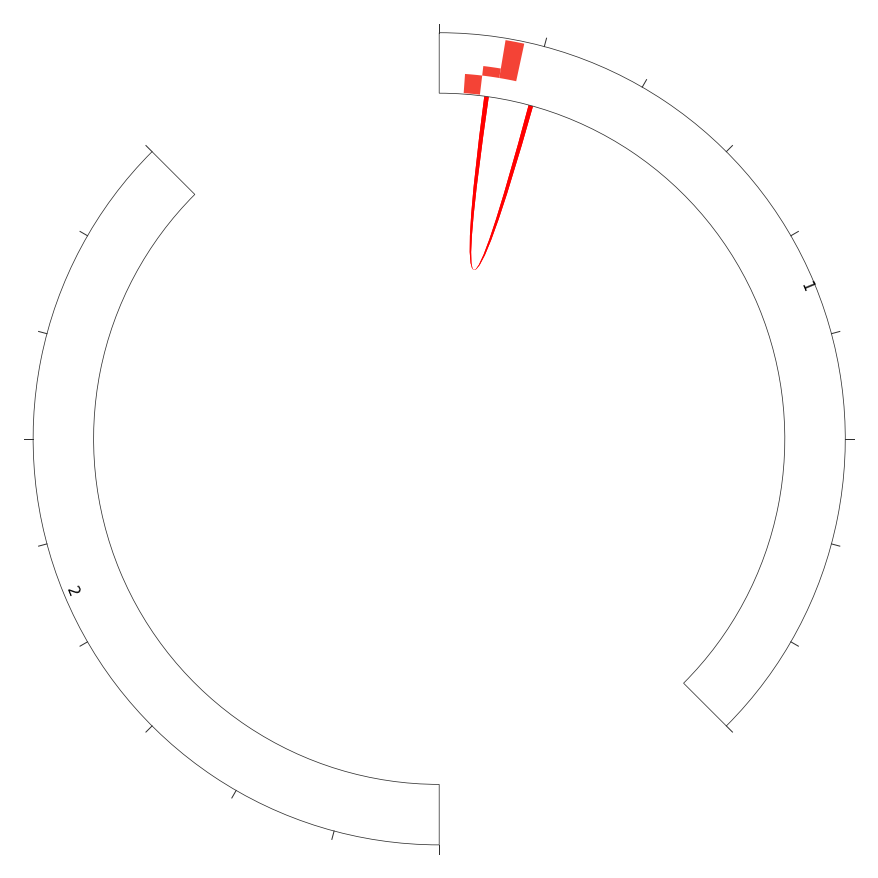

In [51]:
circle.figure

In [408]:
circle.figure.savefig('/home/users/pjh/tmp/circos.pdf')

# Main

### Create 100kb bins

In [5]:
genome_gr = CHROMDICT_HG19.to_gr()
# intvlist = IntervalList.from_chromdict(CHROMDICT_HG19)
hkbins_gr = genome_gr.window(100_000)

In [7]:
hkbins_path = '/home/users/pjh/practice/mosdepth/100kbins.bed.gz'
hkbins_gr.to_bed(hkbins_path)

/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an 

### Set constants

In [9]:
%matplotlib inline

import pycircos
import matplotlib.pyplot as plt

RAXIS_RANGE_LIST = [
    (900, 940),
    (800, 900),
]
FIGSIZE = (12, 12)

### Set functions

In [72]:
# def get_arc_id(chrom, start, end, chromdict):
#     if start == 0 and end == chromdict[chrom]:
#         arc_id = chrom
#     else:
#         arc_id = '_'.join([chrom, str(start), str(end)])
        
#     return arc_id


# def get_arc_id_gr_row(gr_row, chromdict):
#     return get_arc_id(
#         gr_row.Chromosome.iloc[0], 
#         gr_row.Start.iloc[0], 
#         gr_row.End.iloc[0], 
#         chromdict,
#     )


# def get_arc_id_df_row(df_row, chromdict):
#     return get_arc_id(df_row['Chromosome'], df_row['Start'], df_row['End'], chromdict)


def add_arc_id_to_circos_range(circos_range_gr, chromdict):
    def make_col(df):
        arc_ids = list()
        for idx, row in df.iterrows():
            if row['Start'] == 0 and row['End'] == chromdict[row['Chromosome']]:
                arc_id = row['Chromosome']
            else:
                arc_id = '_'.join([row['Chromosome'], str(row['Start']), str(row['End'])])
            arc_ids.append(arc_id)
        return pd.Series(arc_ids)
    
    return circos_range_gr.assign('arc_id', make_col)


def gr_iterrows(gr):
    indexers = (np.eye(gr.df.shape[0]) == 1)
    for row_indexer in indexers:
        yield gr[row_indexer]
        

def modify_data_by_circosrange(data_gr, circos_range_gr, chromdict):
    gr_joined = data_gr.join(circos_range_gr).new_position('intersection')    
    arc_id_list = np.array(gr_joined.arc_id)
    
    result = dict()
    for arc_id in np.unique(arc_id_list):
        data_gr_subset = gr_joined[arc_id_list == arc_id]
        data_gr_subset = data_gr_subset.assign('Start', lambda gr: gr.Start - gr.Start_b)
        data_gr_subset = data_gr_subset.assign('End', lambda gr: gr.End - gr.Start_b)
        result[arc_id] = data_gr_subset
        
    return result


### Load cytoband data

In [73]:
import re

CYTOBAND_COLORS = {
    "gneg": "#FFFFFF00", 
    "gpos25": "#EEEEEE", 
    "gpos50": "#BBBBBB", 
    "gpos75": "#777777", 
    "gpos100": "#000000", 
    "gvar": "#FFFFFF00", 
    "stalk": "#C01E27", 
    "acen": "#D82322",
}

def load_cytoband(cytoband_path, refver):
    result = pr.PyRanges(
        pd.read_table(
            cytoband_path, 
            header=None,
            names=['Chromosome', 'Start', 'End', 'Name', 'Stain']
        )
    )   
    refver = common.RefverDict.converter[refver]
    if refver == 'GRCh37':
        result = result.assign('Chromosome', lambda df: df.Chromosome.apply(lambda x: re.sub('^chr', '', x)))
    
    return result

CYTOBAND_PATHS = {
    'GRCh37': '/home/users/pjh/References/cytoband/cytoBand_hg19.bed',
    'GRCh38': '/home/users/pjh/References/cytoband/cytoBand_hg38.bed',
}
CYTOBAND_GRS = {key: load_cytoband(val, key) for key, val in CYTOBAND_PATHS.items()}

CYTOBAND_PATHS = common.RefverDict(CYTOBAND_PATHS)
CYTOBAND_GRS = common.RefverDict(CYTOBAND_GRS)

### Initialize circle

In [49]:
def init_circle(
    circos_range_gr, chromdict, figsize=(12, 12), interspace_angle=2, 
    interspace_ratio=1/9, circos_angle_range=(0, 360), cytoband_raxis_range=(900, 940),
):
    # filter only assembled contigs
    # indexer = np.array(
    #     [
    #         bool(common.RE_PATS['assembled_chromosome'].fullmatch(x))
    #         for x in circos_range_gr.Chromosome
    #     ]
    # )
    # circos_range_gr = circos_range_gr[indexer].merge().sort()
    
    # interspace_angle_sum = (circos_angle_range[1] - circos_angle_range[0]) * interspace_ratio
    # interspace = interspace_angle_sum / circos_range_gr.df.shape[0]
    
    interspace = interspace_angle    
    circle = pycircos.Gcircle(figsize=figsize)
    
    for idx, row in circos_range_gr.df.iterrows():
        length = row['End'] - row['Start']
        arc_id = row['arc_id']
        circle.add_garc(
            pycircos.Garc(
                arc_id=arc_id, size=length, interspace=interspace, 
                raxis_range=cytoband_raxis_range, 
                labelposition=50, label_visible=True, facecolor='white',
            )
        )
    
    circle.set_garcs(*circos_angle_range)
    
    return circle

### Draw cytobands

In [59]:
def draw_cytoband(circle, circos_range_gr, refver, chromdict, cytoband_raxis_range=(900, 940)):
    cytoband_gr_grouped = modify_data_by_circosrange(CYTOBAND_GRS[refver], circos_range_gr, chromdict)

    for arc_id, cytoband_gr_subset in cytoband_gr_grouped.items():
        positions = list()
        width = list()
        facecolor = list()
        for idx, row in cytoband_gr_subset.df.iterrows():
            positions.append(row['Start'])
            width.append(row['End'] - row['Start'])
            facecolor.append(CYTOBAND_COLORS[row['Stain']])
        data = [1] * len(positions)
            
        circle.barplot(
            arc_id, data=data, positions=positions, width=width, facecolor=facecolor,
            raxis_range=cytoband_raxis_range,
        )
    
    
# arcdata_dict = collections.defaultdict(dict)
# with open("sample_data/example_data_chromosome_cytoband.csv") as f:
#     f.readline()
#     for line in f:
#         line  = line.rstrip().split(",")
#         name  = line[0]     
#         start = int(line[1])-1 
#         width = int(line[2])-(int(line[1])-1) 
#         if name not in arcdata_dict:
#             arcdata_dict[name]["positions"] = []
#             arcdata_dict[name]["widths"]    = [] 
#             arcdata_dict[name]["colors"]    = [] 
#         arcdata_dict[name]["positions"].append(start) 
#         arcdata_dict[name]["widths"].append(width)
#         arcdata_dict[name]["colors"].append(color_dict[line[-1]])

# for key in arcdata_dict:
#     circle.barplot(key, 
#                    data=[1]*len(arcdata_dict[key]["positions"]), 
#                    positions=arcdata_dict[key]["positions"], 
#                    width=arcdata_dict[key]["widths"], 
#                    raxis_range=RAXIS_RANGE_LIST[0], 
#                    facecolor=arcdata_dict[key]["colors"])    
    
    


### Draw point mutations

In [143]:
from handygenome.signature import misc as sig_misc
POINTMT_COLORS = sig_misc.COLORS_SBS6

def add_color_to_pointmt(variants_gr):
    def make_colors(df):
        color_list = list()
        for idx, row in df.iterrows():
            ref = row['REF']
            alt = row['ALT']
            
            if len(ref) == 1 and len(alt) == 1:
                if ref in 'AG':
                    ref = Bio.Seq.complement(ref)
                    alt = Bio.Seq.complement(alt)
                color = POINTMT_COLORS[ref + '>' + alt]
            else:
                color = POINTMT_COLORS['other']
                
            color_list.append(color)
            
        return pd.Series(color_list)
    
    return variants_gr.assign('COLOR', make_colors)


def handle_missing_vaf(variants_gr, missing_value):
    def make_new_vaf(df):
        new_vaf = pd.Series(df.VAF)
        new_vaf[np.isnan(new_vaf)] = missing_value
        return new_vaf
    return variants_gr.assign('VAF', make_new_vaf)

    
def draw_point_mutations(circle, circos_range_gr, variants_gr, chromdict, raxis_range, missing_vaf_value=-0.3):
    variants_gr_edit = add_color_to_pointmt(variants_gr)
    variants_gr_edit = handle_missing_vaf(variants_gr_edit, missing_vaf_value)
    variants_gr_edit = modify_data_by_circosrange(variants_gr_edit, circos_range_gr, chromdict)
    
    has_missing_vaf = any(np.isnan(variants_gr.VAF))
    if has_missing_vaf:
        rlim = (missing_vaf_value, 1)
    else:
        rlim = (0, 1)
    
    for arc_id, variant_gr_subset in variants_gr_edit.items():
        circle.scatterplot(
            arc_id, 
            data=variant_gr_subset.VAF, 
            positions=variant_gr_subset.Start, 
            rlim=rlim,
            raxis_range=raxis_range, 
            facecolor=variant_gr_subset.COLOR, 
            spine=True,
        ) 

### Draw copynumber segments

In [191]:
def load_sequenza_segment(segment_path):
    df = pd.read_table(
        segment_path, 
        names=(
            'Chromosome', 'Start', 'End', 
            'Bf', 'N.BAF', 'sd.BAF', 
            'depth.ratio', 'N.ratio', 'sd.ratio',
            'CNt', 'A', 'B', 'LPP',
        ),
        skiprows=1,
    )
    gr = pr.PyRanges(df=df)
    return gr


def 

In [192]:
segment_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/05_sequenza/14/sequenza_files/analysis_files/14_tumor_segments.txt'
segments_gr = load_sequenza_segment(segment_path)
# df = pd.read_table(
#     segment_path, 
#     names=(
#         'Chromosome', 'Start', 'End', 
#         'Bf', 'N.BAF', 'sd.BAF', 
#         'depth.ratio', 'N.ratio', 'sd.ratio',
#         'CNt', 'A', 'B', 'LPP',
#     ),
#     skiprows=1,
# )


In [193]:
segments_gr

,Chromosome,Start,End,Bf,N.BAF,sd.BAF,depth.ratio,N.ratio,sd.ratio,CNt,A,B,LPP
0,1,12807,1363539,0.460488,606,0.130356,1.016057,34814,0.270826,2,1,1,-6.790665
1,1,1375071,2390715,0.498852,1100,0.106338,1.020515,37882,0.268515,2,1,1,-6.736785
2,1,2390840,2391074,0.149661,9,0.136341,1.749198,18,0.296375,13,13,0,-6.733420
3,1,2391081,2606687,0.312823,352,0.105477,1.024081,8861,0.248500,3,3,0,-6.764507
4,1,2606722,2607162,0.310212,23,0.130362,0.814279,61,0.296649,10,8,2,-6.735624
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,X,61736214,61796964,0.446385,486,0.121418,1.068861,5948,0.311044,3,2,1,-6.734792
1266,X,61797873,61798563,0.194207,25,0.075389,1.285138,109,0.427401,9,9,0,-6.733410
1267,X,61799521,61917095,0.308460,998,0.114559,1.101184,13018,0.333821,3,3,0,-6.749848
1268,X,61917171,154902743,0.227399,3648,0.153063,1.230691,2745421,0.429202,4,4,0,-6.998865


### Testrun

In [197]:
circos_range_gr = pr.PyRanges(chromosomes=['1', '1', '2'], starts=[0, 200, 0], ends=[100, 700, 1000])
# circos_range_gr = pr.PyRanges(chromosomes=['1', '2'], starts=[0, 0], ends=[int(CHROMDICT_HG19['1']), int(CHROMDICT_HG19['2'])])


# lins_chr1 = np.linspace(0, CHROMDICT_HG19['1'], num=4)
# lins_chr2 = np.linspace(0, CHROMDICT_HG19['2'], num=4)
# lins_chr3 = np.linspace(0, CHROMDICT_HG19['3'], num=4)
# circos_range_gr = pr.PyRanges(
#     chromosomes=['1', '2', '3'], 
#     starts=[lins_chr1[1], lins_chr2[1], lins_chr3[1]], 
#     ends=[lins_chr1[2], lins_chr2[2], lins_chr3[2]],
# )



# circos_range_gr = pr.PyRanges(
#     chromosomes=['1', '2', '3'], 
#     starts=[0, 0, 0], 
#     ends=[CHROMDICT_HG19['1'], CHROMDICT_HG19['2'], CHROMDICT_HG19['3']],
# )



# circos_range_gr = CHROMDICT_HG19.to_gr()
# indexer = np.array(
#     [
#         bool(common.RE_PATS['assembled_chromosome'].fullmatch(x))
#         for x in circos_range_gr.Chromosome
#     ]
# )
# circos_range_gr = circos_range_gr[indexer]



# postprocess
circos_range_gr = add_arc_id_to_circos_range(circos_range_gr, CHROMDICT_HG19)

In [198]:
circos_range_gr

,Chromosome,Start,End,arc_id
0,1,0,100,1_0_100
1,1,200,700,1_200_700
2,2,0,1000,2_0_1000


In [203]:
%%capture
circle = init_circle(circos_range_gr, CHROMDICT_HG19, interspace_angle=5)

In [204]:
circle.lineplot(
    '1_200_700', 
    data=[10, 10], 
    positions=[200, 210], 
    rlim=[5, 15], 
    raxis_range=(755,835), 
    linecolor="royalblue", 
    spine=True,
) 

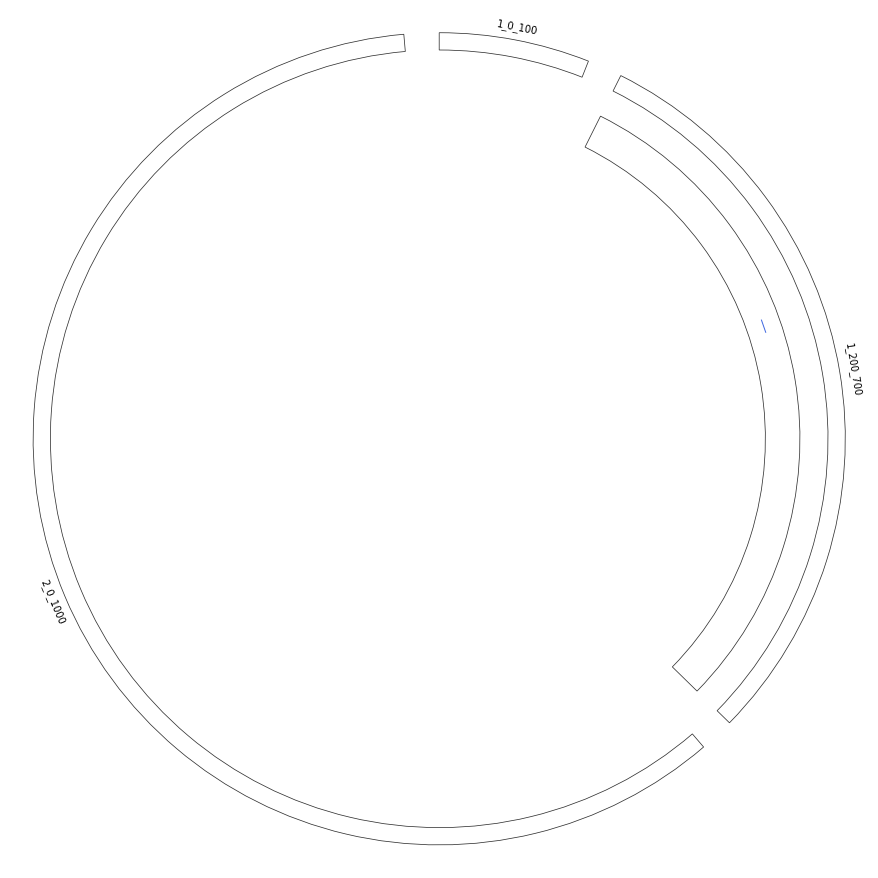

In [205]:
circle.figure

In [167]:
draw_cytoband(circle, circos_range_gr, refver='hg19', chromdict=CHROMDICT_HG19)

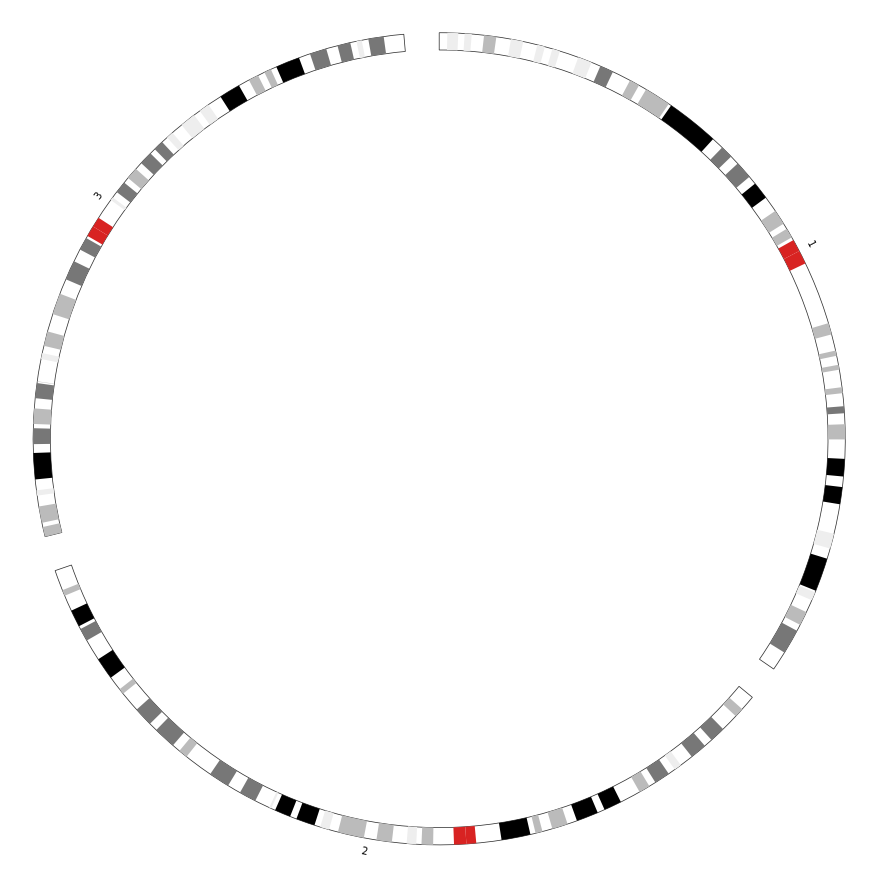

In [168]:
circle.figure

In [169]:
vcf_path = PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV['LU-14']
vcf = VcfPlus(vcf_path)

In [170]:
variants_gr = vcf.vplist.get_gr()
# variants_gr_grouped = modify_data_by_circosrange(variants_gr, circos_range_gr, CHROMDICT_HG19)

In [171]:
raxis_range_pointmt = (800, 900)
draw_point_mutations(circle, circos_range_gr, variants_gr, chromdict=CHROMDICT_HG19, raxis_range=raxis_range_pointmt, missing_vaf_value=-0.3)

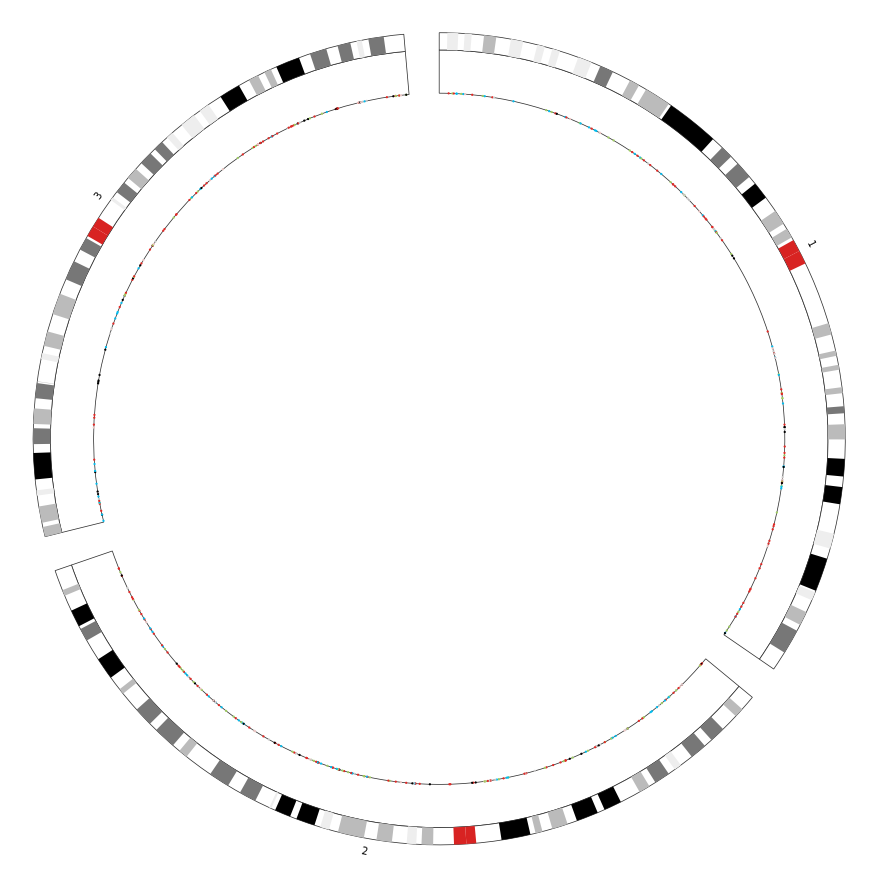

In [172]:
circle.figure